# Compte rendu de TP du 27/03 - Introduction LBM

### Importation des librairies

In [1]:
using LinearAlgebra    # For matrix computations
using Plots            # For plotting
using LaTeXStrings     # For writing LaTeX in code
using Interpolations   # For computing interpolation, useful for animation
using BenchmarkTools   # For Evaluating the performance of our code

In [130]:
# Initialisation
m_init(u₀::Vector, ϕ::Base.Callable) = transpose(hcat(u₀, equilibrium(u₀, ϕ)))
f_init(m::AbstractMatrix, λ::Real) = m2f(m,λ)

# Moment matrix
M(λ::Real) = [1 1; -λ λ]
Minv(λ::Real) = [0.5 -0.5*(1.0/λ); 0.5 0.5*(1.0/λ)]

# Conversion to moment
f2m(f::AbstractMatrix, λ::Real) = reduce(hcat, [M(λ) * f[:,i] for i in axes(f)[2]])
m2f(m::AbstractMatrix, λ::Real) = reduce(hcat, [Minv(λ) * m[:,i] for i in axes(m)[2]])
f2m!(m::AbstractMatrix, f::AbstractMatrix, λ::Real) = m .= reduce(hcat, [M(λ) * f[:,i] for i in axes(f)[2]])
m2f!(f::AbstractMatrix, m::AbstractMatrix, λ::Real) = f .= reduce(hcat, [Minv(λ) * m[:,i] for i in axes(m)[2]])

# Equilibrium
equilibrium(m₀::Vector, ϕ::Base.Callable) = ϕ.(m₀)

# Relaxation
function relaxation!(m::AbstractMatrix, s₁::Real, ϕ::Base.Callable)
    @inbounds m[1,:] .= m[1,:]
    @inbounds m[2,:] .= m[2,:] .+ s₁ .* (equilibrium(m[1,:], ϕ) .- m[2,:])
end

# Streaming
function streaming!(f::AbstractMatrix)
    @inbounds f[1,1:end-1] .= f[1,2:end]
    @inbounds f[2,2:end]   .= f[2,1:end-1]
end

# Compute the dynamics
function solve(u₀fun::Base.Callable, ϕ::Base.Callable; Nₜ::Int = -1, T::Real, Nₓ::Int, xmax::Real, xmin::Real, s::Real, λ::Real = -1, collision!::Base.Callable)

    # INPUTS
    #   - u₀fun     : Function of space that gives the initial condition,
    #   - ϕ         : Function related to the equation we want to simulate,
    #   - Nₜ         : Number of timestep,
    #   - T         : Endtime of the solution computed,
    #   - Nₓ        : Number of point in the mesh
    #   - xmax      : Right edge of the space domain,
    #   - xmin      : Left edge of the space domain,
    #   - s         : Parameter of relaxation  

    # OUTPUTS
    #   - A solution u through time on the domain [xmin,xmax]x[0,T] of the equation 
    #                       ∂ₜu + ∂ₓφ(u) = 0

    # Parameters of the simulation
    @assert max(Nₜ, λ) > 0
    @assert min(Nₜ, λ) < 0

    Δx = (xmax - xmin)/(Nₓ+1)
    if λ > 0
        _λ = λ
        Δt = Δx/_λ
        Nₜ = Int(round(T/Δt))
        T = Δt * Nₜ
    else 
        Δt = T/Nₜ
        _λ = Δx/Δt
    end
   
    # Mesh
    mesh = LinRange(xmin-0.5*Δx,xmax+0.5*Δx,Nₓ+2)

    # Initialisation 
    u₀ = u₀fun(mesh)
    m = m_init(u₀, ϕ)
    f = f_init(m, _λ)

    # Storage for the solution
    sol = zeros(Nₜ+1,Nₓ)
    sol[1,:] = m[1,2:end-1]
    
    # Loop for each timestep
    for i in 1:Nₜ
        relaxation!(m, s, ϕ)
        m2f!(f, m, _λ)
        collision!(f, λ, c)
        streaming!(f)
        f2m!(m, f, _λ)
        sol[i+1,:] =  m[1,2:end-1]
    end
    λ > 0 ? (sol,T) : sol
end

solve (generic function with 1 method)

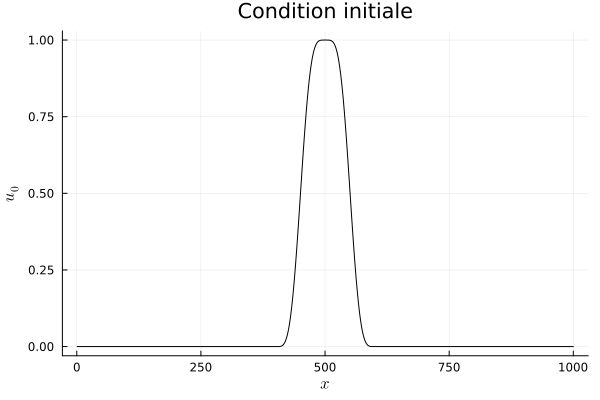

In [3]:
function u_init(X::AbstractVector, reg::Int, middle::Real, swidth::Real)

    # Parameters to localise the bump part
    xmin, xmax = min(X...), max(X...)
    width = swidth*(xmax - xmin)
    x_left, x_right = middle - width, middle + width

    # Array to store the output
    output = zero(X)

    ind_l = findall(x -> x > x_left && x <= middle, X)
    ind_r = findall(x -> x < x_right && x > middle, X)

    x_sl = (X[ind_l] .- x_left .- 0.5 * width) ./ (0.5 * width)
    x_sl_k = copy(x_sl)
    x_sl .= x_sl.^2
    x_sr = (X[ind_r] .- middle .- 0.5 * width) ./ (0.5 * width)
    x_sr_k = copy(x_sr)
    x_sr .= x_sr.^2

    cte = 0.0
    for k in 0:reg
        coeff = (-1)^k * binomial(reg, k) / (2 * k + 1)   # binomial is an inbuilt function in Julia
        output[ind_l] .+= coeff .* x_sl_k
        output[ind_r] .-= coeff .* x_sr_k
        cte += coeff
        x_sl_k .*= x_sl
        x_sr_k .*= x_sr
    end
    output[ind_l] .+= cte
    output[ind_r] .+= cte
    output ./= 2 * cte

    output
end

# Plot of an example of the initial condition
plot(u_init(collect(LinRange(0,1,1000)), 4, 0.5, 0.1), legend=:false, c=:black)
xlabel!(L"x")
ylabel!(L"u_0")
title!("Condition initiale")

In [4]:
function animation(sol::AbstractMatrix; d::Real = 5, fps::Int = 30, Lmax::Real, Lmin::Real, T::Real, label::String = "")

    # INPUTS
    #   - sol       : Solution Matrix given by the dynamics function,
    #   - d         : Duration wanted for the animation,
    #   - fps       : Number of frame per secondes,
    #   - Lmax      : Number of frame per secondes,
    #   - Lmin      : Number of frame per secondes,
    #   - T         : Final to time of the simulation to print the current physical time,

    # OUTPUTS
    #   - An animation of the solution through the time
    
    # Total frame
    nbframe = fps * d
  
    # Time and space vector
    Nₜ, Nₓ = size(sol)
    time = range(0,1,Nₜ)
    mesh = LinRange(Lmin,Lmax,Nₓ)
    
    # Constante to fix the yaxis
    M = max(sol...)
    m = min(sol...)

    anim = @animate for n in 1:nbframe
        # Actual frame
        t = n / (fps*d)
        # Interpolation
        interp= [linear_interpolation(time, sol[:,i])(t) for i in 1:Nₓ]
        # Plots
        plot(mesh, interp, ylim = [m*1.1^(m),M*1.1^(M)], c = :black, label = label)
        xlabel!(L"x")
        ylabel!(L"u")
        title!("t = "*string(round(t*T; digits = 3)))
    end
  
    gif(anim, fps = fps)
  end

animation (generic function with 1 method)

## **Exercice 1 : Equation d'advection**

In [5]:
# Advection
advection(u::Real, c::Real) = c*u

advection (generic function with 1 method)

### **Condition périodique**

In [164]:
function periodic!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = f[1,2]
    f[2,1]   = f[2,end-1]
end

periodic! (generic function with 2 methods)

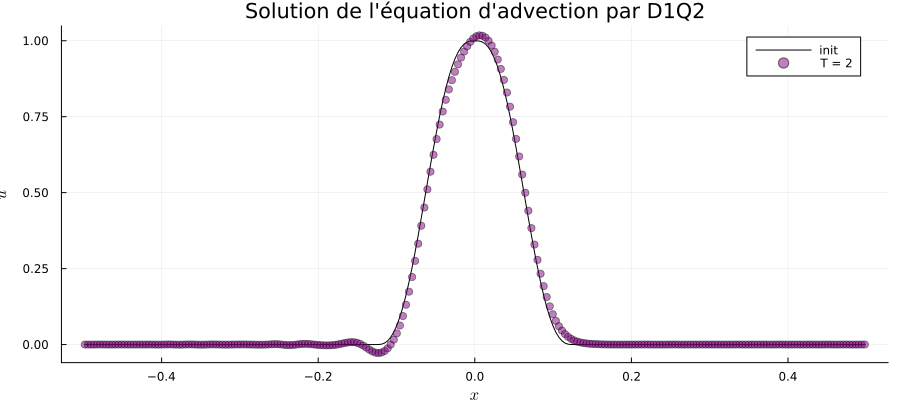

In [165]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width )   # regularity 2, center in -0.25 and with a witdh of 0.125 of the length of the domain

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 2.0 
Nₓ = 256
Nₜ = 512
s = 2.0
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)

# Resolution
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!)

# Exact solution
sol_exact = u₀fun(mesh)

# Plot
plot(mesh, sol[1,:], label ="init", size = (900,400), c=:black)
scatter!(mesh, sol[end,:], label = "T = 2", markershape=:circle, ma = 0.5, mc = :purple)
xlabel!(L"x")
ylabel!(L"u")
title!("Solution de l'équation d'advection par D1Q2")

┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_lWJEvI5enq.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_lWJEvI5enq.gif")
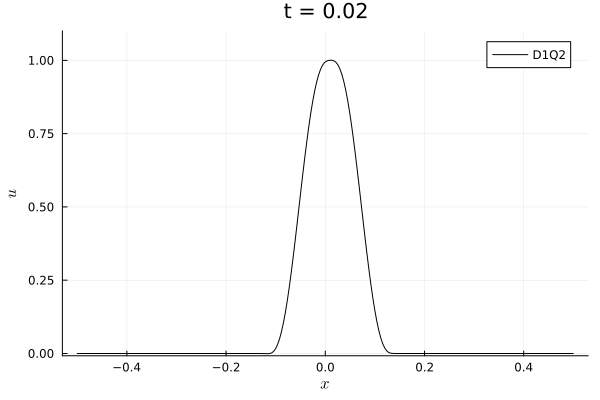

In [86]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 2.0  
Nₓ = 256
Nₜ = 400
s = 1.9

# Computation of the solutions
sol_exact = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = periodic!)

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "D1Q2")

### **Bounce back**

In [100]:
function bounce_back!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = f[2,end-1]
    f[2,1]   = f[1,2]
end

bounce_back! (generic function with 1 method)

┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_zk5Wb0RANg.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_zk5Wb0RANg.gif")
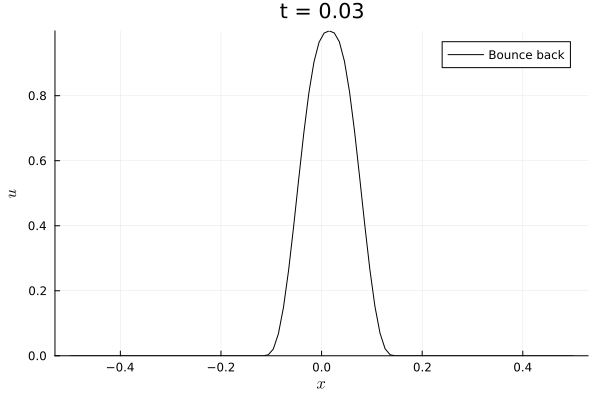

In [104]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 3.0  
Nₓ = 100
Nₜ = 150
s = 2.0

# Computation of the solutions
sol_exact = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = bounce_back!)

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Bounce back")

### **Anti - Bounce back**

In [143]:
function antibounce_back!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = -f[2,end-1]
    f[2,1]   = -f[1,2]
end

antibounce_back! (generic function with 2 methods)

λ = Nₜ / (Nₓ * Tf) = 1.0


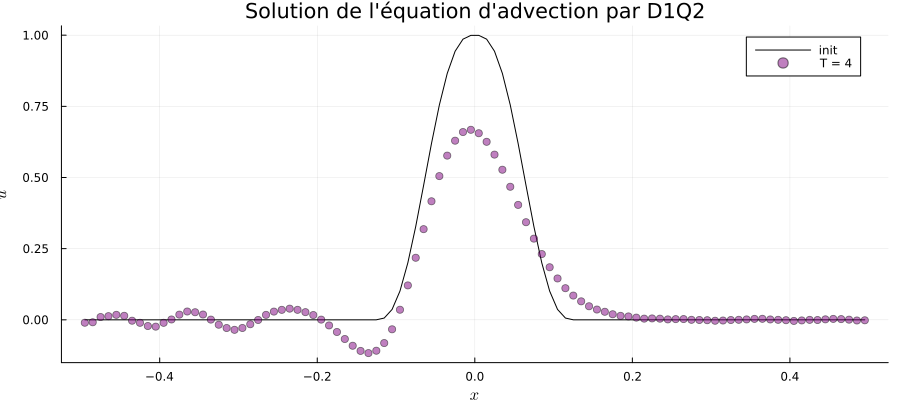

In [126]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width )   # regularity 2, center in -0.25 and with a witdh of 0.125 of the length of the domain

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.25
Tf = 8.0 
Nₓ = 100
Nₜ = 800
s = 1.999
Δx = (xmax - xmin)/(Nₓ+1)
mesh = LinRange(xmin+0.5*Δx,xmax-0.5*Δx,Nₓ)
@show λ = Nₜ/(Nₓ*Tf)

# Resolution
sol = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Exact solution
sol_exact = u₀fun(mesh)

# Plot
plot(mesh, sol[1,:], label ="init", size = (900,400), c=:black)
scatter!(mesh, sol[end,:], label = "T = 4", markershape=:circle, ma = 0.5, mc = :purple)
xlabel!(L"x")
ylabel!(L"u")
title!("Solution de l'équation d'advection par D1Q2")

λ = Nₜ / (Nₓ * Tf) = 1.0


┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_7qbEzIlspY.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_7qbEzIlspY.gif")
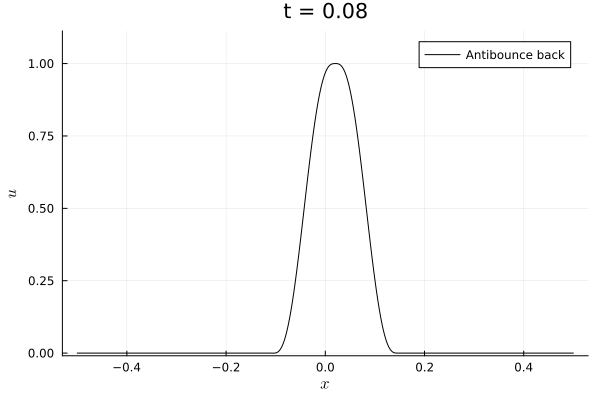

In [154]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.25
Tf = 8.0  
Nₓ = 1000
Nₜ = 8000
s = 2.0
@show λ = Nₜ/(Nₓ*Tf)

# Computation of the solutions
sol_exact = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = antibounce_back!)

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Antibounce back")

### **Copy Condition**

In [74]:
function copy_condition!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = f[1,end-1]
    f[2,1]   = f[2,2]
end

copy_condition! (generic function with 1 method)

┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_1072J6RKDU.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_1072J6RKDU.gif")
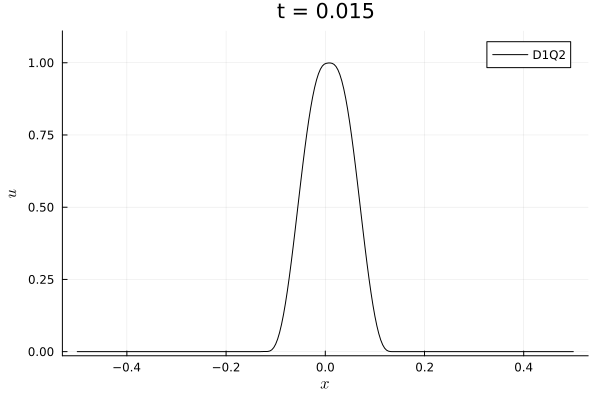

In [90]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.5
Tf = 1.5  
Nₓ = 256
Nₜ = 300
s = 2.0

# Computation of the solutions
sol_exact = solve(u₀fun, x -> advection(x, c); Nₜ = Nₜ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = copy_condition!)

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Copy condition")

### **Condition sortante**

In [148]:
function sortante!(f::AbstractMatrix, λ::Real, c::Real)
    f[1,end] = (λ-c)/(λ + c) * f[2,end-1]
    f[2,1]   = -f[1,2]
end

sortante! (generic function with 1 method)

┌ Info: Saved animation to C:\Users\theoz\AppData\Local\Temp\jl_hUhiTcPkli.gif
└ @ Plots C:\Users\theoz\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\theoz\\AppData\\Local\\Temp\\jl_hUhiTcPkli.gif")
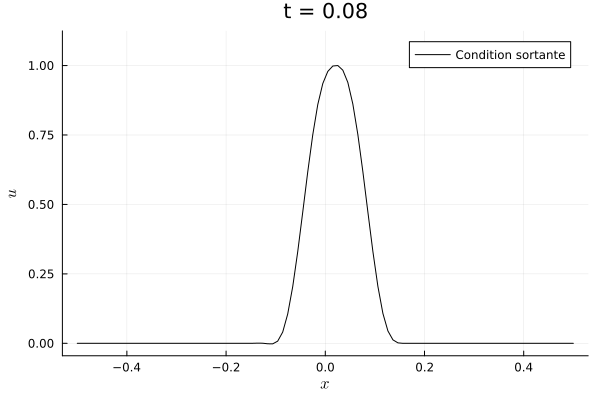

In [151]:
# Initial condition
center = 0.0
width = 0.125
u₀fun(x) = u_init(x, 2, center, width ) 

# Parameters
xmax = 0.5
xmin = -0.5
c = 0.25
Tf = 8.0  
Nₓ = 100
s = 2.0
λ = 0.3

# Computation of the solutions
sol_exact = solve(u₀fun, x -> advection(x, c); λ = λ, T = Tf, Nₓ = Nₓ, xmax = xmax, xmin = xmin, s = s, collision! = sortante!)[1]

# Creation of the animation
animation(sol_exact; d = 10, fps = 10, Lmax = xmax, Lmin = xmin, T = Tf, label = "Condition sortante")

## **Exercice 2 : Equation de Burgers**